Code source: Tutorial by Giorgio Domenichini

CPHF: CPHF (Coupled Perturbed Hartree-Fock) alchemical derivatives are quantities used in computational chemistry and quantum chemistry to calculate the change in molecular properties with respect to changes in the nuclear positions or atomic charges.

Gaussian-type orbitals (GTOs) are mathematical functions commonly used to represent atomic orbitals in quantum chemistry calculations. They are named after the Gaussian distribution function that describes their radial behavior. GTOs provide a flexible and efficient basis for approximating the wavefunctions of electrons in molecules.

Basis sets are a set of mathematical functions that are used to approximate the wave functions of electrons in molecules

In [1]:
import sys
sys.path.append('../APDFT')
sys.path.append('../Data')

In [46]:
from pyscf import gto,scf
import numpy as np
import pandas as pd
import pyscf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import basis_set_exchange as bse
from FcMole import FcM, FcM_like
import os
import ast
from IPython.display import display

%load_ext autoreload
%autoreload 2
from AP_class import APDFT_perturbator as AP

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# mol_NN = gto.M(atom= "N 0 0 0; N 0 0 2.1",
#                unit="Bohr",
#                basis="unc-cc-pvdz")

# mol_NN_pcX2=gto.M(atom= "N 0 0 0; N 0 0 2.1",
#                   unit="Bohr",
#                   basis=bse.get_basis('pcX-2',fmt="nwchem",elements=[6,7,8]))

In [ ]:
# mf = scf.RKS(mol_NN) # create a restricted Kohn-Sham (RKS) mean-field object used for electronic structure calculation
# mf.xc = "PBE0" # sets the exchange-correlation (XC) functional to "PBE0"
# energy = mf.scf()

In [ ]:
# ap_nn=AP(mf,sites=[0,1]) # prepare to perform alchemical perturbing DFT calculations
# H = ap_nn.build_hessian()
# print(H)

## Calculating Hessian ##

In [3]:
# create the NN molecule
mol_NN = gto.M(atom= "N 0 0 0; N 0 0 2.1",
               unit="Bohr",
               basis="unc-cc-pvdz")

In [4]:
def get_energy_DFT(mol):
    """ 
    Compute the total energy of a given molecule, in a.u., using DFT calculation

    Args:
        mol (pyscf.gto.mole.Mole): a PySCF Gaussian-type orbital (GTO) molecule object 
    
    Returns:
        mf (pyscf.dft.rks.RKS): the mean-field object for the molecule (used for other DFT related calculations) 
        energy (float): the total energy of the molecule
    """

    mf = scf.RKS(mol) # create a restricted Kohn-Sham (RKS) mean-field object used for electronic structure calculation
    mf.xc = "PBE0" # sets the exchange-correlation (XC) functional to "PBE0"
    energy = mf.scf() # performs self-consistent field (SCF) calculations

    return energy, mf

In [5]:
def get_energy_HF(mol):
    """ 
    Compute the total energy of a given molecule, in a.u., using DFT calculation

    Args:
        mol (pyscf.gto.mole.Mole): a PySCF Gaussian-type orbital (GTO) molecule object 
    
    Returns:
        mf (pyscf.dft.rks.RKS): the mean-field object for the molecule (used for other DFT related calculations) 
        energy (float): the total energy of the molecule
    """

    mf = scf.RHF(mol) # create a restricted Hartree-Fock (RHF) mean-field object used for electronic structure calculation
    energy = mf.scf() # performs self-consistent field (SCF) calculations

    return energy, mf

In [6]:
# Calculate the energy and the Hessian

energy_nn, mf_nn = get_energy_DFT(mol_NN)
ap_nn=AP(mf_nn,sites=[0,1]) # prepare to perform alchemical perturbing DFT calculations
H = ap_nn.build_hessian()
print(H)

converged SCF energy = -109.415080022349
[[-3.26630067  0.50149887]
 [ 0.50149887 -3.26630067]]


In [7]:
# compute the diagnalization matrix (of eigenvectors) Q

epsilon, Q = np.linalg.eig(H)
Q_inv = np.linalg.inv(Q)
print(Q_inv)
print(epsilon)

[[-0.70710678  0.70710678]
 [-0.70710678 -0.70710678]]
[-3.76779954 -2.76480179]


## Get Training Data ##

In [21]:
element_dict = {0: None, 1: 'H', 2: 'He',
                3: 'Li', 4: 'Be', 5: 'B', 6: 'C', 7: 'N', 8: 'O', 9: 'F', 10: 'Ne',
                11: 'Na', 12: 'Mg', 13: 'Al', 14: 'Si', 15: 'P', 16: 'S', 17: 'Cl', 18: 'Ar',
                19: 'K', 20: 'Ca'}

In [64]:
def generate_diatomic_data():
    """ 
    Generate diatomic energy data from scratch using DFT calculation.
    The generated DataFrame will have the following columns: charge, net charge, element, dx, energy

    Args: None
    
    Returns:
        diatomic_data (pandas DataFrame): DataFrame containing the energy of each molecule, along with other information
    """
    
    # create an empty DataFrame with 3 columns: charge, element, energy
    columns = ['charge', 'net charge', 'element', 'dx', 'energy']
    diatomic_data = pd.DataFrame(columns=columns)

    # generate all charge combinations (fractional included) for 14-electron diatomic molecules
    # net charges include 0, 1+, 2+, 1-
    neutral_values = np.arange(0.1, 14, 0.1)
    neutral_charges = np.column_stack((neutral_values, 14 - neutral_values))
    neutral_charges = np.round(charges, decimals = 1)
    
    plus_one_values = np.arange(0.1, 15, 0.1)
    plus_one_charges = np.column_stack((plus_one_values, 15 - plus_one_values)) 
    plus_one_charges = np.round(charges, decimals = 1)
    
    plus_two_values = np.arange(0.1, 16, 0.1)
    plus_two_charges = np.column_stack((plus_two_values, 16 - plus_two_values)) 
    plus_two_charges = np.round(plus_two_charges, decimals = 1)

    minus_one_values = np.arange(0.1, 13, 0.1)
    minus_one_charges = np.column_stack((minus_one_values, 16 - minus_one_values)) 
    minus_one_charges = np.round(minus_one_charges, decimals = 1)  
    
    charges = np.vstack((neutral_charges, plus_one_charges, plus_two_charges, minus_one_charges))

    diatomic_data['charge'] = charges.tolist()
    diatomic_data['net charge'] = diatomic_data['charge'].apply(lambda x: sum(x) - 14)
 
    # compute the energy for each molecule
    for index, row in diatomic_data.iterrows():
        charges = row['charge']

        # compute the dx value (i.e. charge perturbation with respect to NN)
        dx = [charges[0] - 7, charges[1] - 7]
        dx = np.round(dx, decimals = 1).tolist()
        diatomic_data.at[index, 'dx'] = dx
        
        # print current process
        if (index % 10 == 0):
            print(f"dx: {dx}")

        # create a new molecule from dx and calculate its energy
        target_mol = FcM_like(mol_NN, fcs=dx) # create a new molecule
        target_mf = scf.RKS(target_mol) 
        target_mf.xc = "PBE0"
        target_mf.verbose = False
        target_energy = target_mf.scf(dm0=target_mf.init_guess_by_1e())
        diatomic_data.at[index, 'energy'] = target_energy 
        
        # if the charge take integer values, note down the corresponding molecule
        if all(charge.is_integer() for charge in charges): 
            int_charges = [int(charge) for charge in charges] 
            diatomic_data.at[index, 'element'] = [element_dict[charge] for charge in int_charges]

        return diatomic_data 

In [65]:
def load_diatomic_data():
    """ 
    Get the diatomic molecule data and store them in pandas dataframe
    If there exist a file with pre-calculated diatomic energy, directly open it.
    If not, calculate the energy for each molecule and store the data as a separate file

    Args: None
    
    Returns:
        diatomic_data (pandas DataFrame): DataFrame containing the energy of each molecule, along with other information
    """
    
    if os.path.isfile('../Data/extended_diatomic_data_w_energy.csv'):
        diatomic_data = pd.read_csv('../Data/extended_diatomic_data_w_energy.csv', sep='\t', header = 0)
    else:
        diatomic_data = generate_diatomic_data()
    return diatomic_data

### Neutral Molecules ###

In [66]:
diatomic_data = load_diatomic_data()

ParserError: Error tokenizing data. C error: Expected 3 fields in line 11, saw 4


In [27]:
# create an empty DataFrame with 3 columns: charge, element, energy
columns = ['charge', 'element', 'dx', 'energy']
diatomic_data = pd.DataFrame(columns=columns)

# generate all charge combinations (fractional included) for neutral 14-electron diatomic molecules
values = np.arange(0.1, 14, 0.1)
charges = np.column_stack((values, 14 - values)) # stack (value, 14 - values) as columns into 2D array
charges = np.round(charges, decimals = 1) # round all values to 1 decimal place
diatomic_data['charge'] = charges.tolist() # store the data in the 'charge' column of the DataFrame

# compute the energy for each molecule
for index, row in diatomic_data.iterrows():
    charges = row['charge']

    # compute the dx value (i.e. charge perturbation with respect to NN)
    dx = [charges[0] - 7, charges[1] - 7]
    dx = np.round(dx, decimals = 1).tolist()
    diatomic_data.at[index, 'dx'] = dx
    
    # print current process
    if (index % 10 == 0):
        print(f"current dx: {dx}")

    # create a new molecule from dx and calculate its energy
    target_mol = FcM_like(mol_NN, fcs=dx) # create a new molecule
    target_mf = scf.RKS(target_mol) 
    target_mf.xc = "PBE0"
    target_mf.verbose = False
    target_energy = target_mf.scf(dm0=target_mf.init_guess_by_1e())
    diatomic_data.at[index, 'energy'] = target_energy 
    
    # if the charge take integer values, note down the corresponding molecule
    if all(charge.is_integer() for charge in charges): # check if all charges in 'charge' are integers
        int_charges = [int(charge) for charge in charges] # convert charges from float to int type
        diatomic_data.at[index, 'element'] = [element_dict[charge] for charge in int_charges] # generate list of elements using the element_dict mapping

# display(diatomic_data.head(30))

current dx: [-6.9, 6.9]


/home/gabrielwu2004/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1213: UserWarning: Function mol.dumps drops attribute with_rinv_at_nucleus because it is not JSON-serializable
  warnings.warn(msg)


current dx: [-5.9, 5.9]
current dx: [-4.9, 4.9]
current dx: [-3.9, 3.9]
current dx: [-2.9, 2.9]
current dx: [-1.9, 1.9]
current dx: [-0.9, 0.9]
current dx: [0.1, -0.1]
current dx: [1.1, -1.1]
current dx: [2.1, -2.1]
current dx: [3.1, -3.1]
current dx: [4.1, -4.1]
current dx: [5.1, -5.1]
current dx: [6.1, -6.1]


,charge,element,dx,energy
0,"[0.1, 13.9]",NaN,"[-6.9, 6.9]",-282.512821
1,"[0.2, 13.8]",NaN,"[-6.8, 6.8]",-277.699197
2,"[0.3, 13.7]",NaN,"[-6.7, 6.7]",-273.041699
3,"[0.4, 13.6]",NaN,"[-6.6, 6.6]",-268.366512
4,"[0.5, 13.5]",NaN,"[-6.5, 6.5]",-263.747315
5,"[0.6, 13.4]",NaN,"[-6.4, 6.4]",-259.184728
6,"[0.7, 13.3]",NaN,"[-6.3, 6.3]",-254.679414
7,"[0.8, 13.2]",NaN,"[-6.2, 6.2]",-250.232069
8,"[0.9, 13.1]",NaN,"[-6.1, 6.1]",-245.843424
9,"[1.0, 13.0]","[H, Al]","[-6.0, 6.0]",-241.514231


In [30]:
diatomic_data['net charge'] = diatomic_data['charge'].apply(lambda x: sum(x) - 14)
column_order = ['charge', 'net charge', 'element', 'dx', 'energy']
diatomic_data = diatomic_data[column_order]
display(diatomic_data.head(10))

,charge,net charge,element,dx,energy
0,"[0.1, 13.9]",0.0,NaN,"[-6.9, 6.9]",-282.512821
1,"[0.2, 13.8]",0.0,NaN,"[-6.8, 6.8]",-277.699197
2,"[0.3, 13.7]",0.0,NaN,"[-6.7, 6.7]",-273.041699
3,"[0.4, 13.6]",0.0,NaN,"[-6.6, 6.6]",-268.366512
4,"[0.5, 13.5]",0.0,NaN,"[-6.5, 6.5]",-263.747315
5,"[0.6, 13.4]",0.0,NaN,"[-6.4, 6.4]",-259.184728
6,"[0.7, 13.3]",0.0,NaN,"[-6.3, 6.3]",-254.679414
7,"[0.8, 13.2]",0.0,NaN,"[-6.2, 6.2]",-250.232069
8,"[0.9, 13.1]",0.0,NaN,"[-6.1, 6.1]",-245.843424
9,"[1.0, 13.0]",0.0,"[H, Al]","[-6.0, 6.0]",-241.514231


In [31]:
diatomic_data.to_csv('../Data/extended_diatomic_data_w_energy.csv', sep='\t')

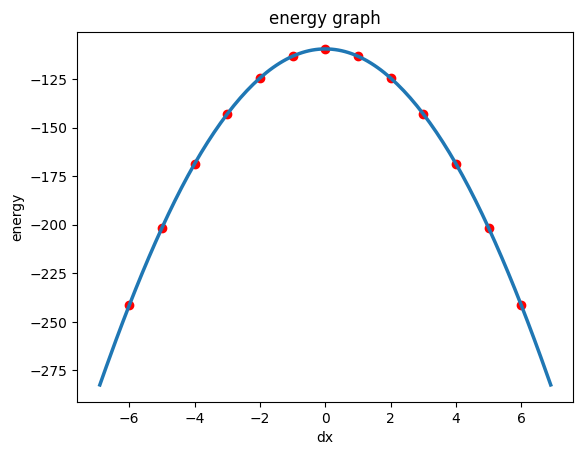

In [36]:
# Plot energy

x = diatomic_data['dx'].apply(lambda x: x[0])
y = diatomic_data['energy']
integer_x = x[x.astype(int) == x]
integer_y = y[x.astype(int) == x]

plt.plot(x, y, linestyle='-', linewidth=2.5)
plt.scatter(integer_x, integer_y, color='red', marker='o')

plt.xlabel('dx')
plt.ylabel('energy')
plt.title('energy graph')

plt.show()


### Charge +1 ###

In [38]:
columns = ['charge', 'net charge', 'element', 'dx', 'energy']
diatomic_data_one_plus = pd.DataFrame(columns=columns)

# generate all charge combinations (fractional included) for 14-electron diatomic molecules with 1+ charge
values = np.arange(0.1, 15, 0.1)
charges = np.column_stack((values, 15 - values)) 
charges = np.round(charges, decimals = 1) 
diatomic_data_one_plus['charge'] = charges.tolist()

diatomic_data_one_plus['net charge'] = diatomic_data_one_plus['charge'].apply(lambda x: sum(x) - 14)

# compute the energy for each molecule
for index, row in diatomic_data_one_plus.iterrows():
    charges = row['charge']

    # compute the dx value (i.e. charge perturbation with respect to NN)
    dx = [charges[0] - 7, charges[1] - 7]
    dx = np.round(dx, decimals = 1).tolist()
    diatomic_data_one_plus.at[index, 'dx'] = dx
    
    # print current process
    if (index % 10 == 0):
        print(f"current dx: {dx}")

    # create a new molecule from dx and calculate its energy
    target_mol = FcM_like(mol_NN, fcs=dx) # create a new molecule
    target_mf = scf.RKS(target_mol) 
    target_mf.xc = "PBE0"
    target_mf.verbose = False
    target_energy = target_mf.scf(dm0=target_mf.init_guess_by_1e())
    diatomic_data_one_plus.at[index, 'energy'] = target_energy 
    
    # if the charge take integer values, note down the corresponding molecule
    if all(charge.is_integer() for charge in charges): # check if all charges in 'charge' are integers
        int_charges = [int(charge) for charge in charges] # convert charges from float to int type
        diatomic_data_one_plus.at[index, 'element'] = [element_dict[charge] for charge in int_charges] # generate list of elements using the element_dict mapping

current dx: [-6.9, 7.9]


/home/gabrielwu2004/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1213: UserWarning: Function mol.dumps drops attribute with_rinv_at_nucleus because it is not JSON-serializable
  warnings.warn(msg)


current dx: [-5.9, 6.9]
current dx: [-4.9, 5.9]
current dx: [-3.9, 4.9]
current dx: [-2.9, 3.9]
current dx: [-1.9, 2.9]
current dx: [-0.9, 1.9]
current dx: [0.1, 0.9]
current dx: [1.1, -0.1]
current dx: [2.1, -1.1]
current dx: [3.1, -2.1]
current dx: [4.1, -3.1]
current dx: [5.1, -4.1]
current dx: [6.1, -5.1]
current dx: [7.1, -6.1]


,charge,net charge,element,dx,energy
0,"[0.1, 13.9]",0.0,NaN,"[-6.9, 6.9]",-282.512821
1,"[0.2, 13.8]",0.0,NaN,"[-6.8, 6.8]",-277.699197
2,"[0.3, 13.7]",0.0,NaN,"[-6.7, 6.7]",-273.041699
3,"[0.4, 13.6]",0.0,NaN,"[-6.6, 6.6]",-268.366512
4,"[0.5, 13.5]",0.0,NaN,"[-6.5, 6.5]",-263.747315
5,"[0.6, 13.4]",0.0,NaN,"[-6.4, 6.4]",-259.184728
6,"[0.7, 13.3]",0.0,NaN,"[-6.3, 6.3]",-254.679414
7,"[0.8, 13.2]",0.0,NaN,"[-6.2, 6.2]",-250.232069
8,"[0.9, 13.1]",0.0,NaN,"[-6.1, 6.1]",-245.843424
9,"[1.0, 13.0]",0.0,"[H, Al]","[-6.0, 6.0]",-241.514231


In [40]:
display(diatomic_data_one_plus.head(20))

,charge,net charge,element,dx,energy
0,"[0.1, 14.9]",1.0,NaN,"[-6.9, 7.9]",-332.735906
1,"[0.2, 14.8]",1.0,NaN,"[-6.8, 7.8]",-327.474789
2,"[0.3, 14.7]",1.0,NaN,"[-6.7, 7.7]",-322.361158
3,"[0.4, 14.6]",1.0,NaN,"[-6.6, 7.6]",-317.241463
4,"[0.5, 14.5]",1.0,NaN,"[-6.5, 7.5]",-312.178374
5,"[0.6, 14.4]",1.0,NaN,"[-6.4, 7.4]",-307.172597
6,"[0.7, 14.3]",1.0,NaN,"[-6.3, 7.3]",-302.224856
7,"[0.8, 14.2]",1.0,NaN,"[-6.2, 7.2]",-297.335885
8,"[0.9, 14.1]",1.0,NaN,"[-6.1, 7.1]",-292.506424
9,"[1.0, 14.0]",1.0,"[H, Si]","[-6.0, 7.0]",-287.737201


In [41]:
columns = ['charge', 'net charge', 'element', 'dx', 'energy']
diatomic_data_two_plus = pd.DataFrame(columns=columns)

# generate all charge combinations (fractional included) for 14-electron diatomic molecules with 1+ charge
values = np.arange(0.1, 16, 0.1)
charges = np.column_stack((values, 16 - values)) 
charges = np.round(charges, decimals = 1) 
diatomic_data_two_plus['charge'] = charges.tolist()

diatomic_data_two_plus['net charge'] = diatomic_data_two_plus['charge'].apply(lambda x: sum(x) - 14)

# compute the energy for each molecule
for index, row in diatomic_data_two_plus.iterrows():
    charges = row['charge']

    # compute the dx value (i.e. charge perturbation with respect to NN)
    dx = [charges[0] - 7, charges[1] - 7]
    dx = np.round(dx, decimals = 1).tolist()
    diatomic_data_two_plus.at[index, 'dx'] = dx
    
    # print current process
    if (index % 10 == 0):
        print(f"current dx: {dx}")

    # create a new molecule from dx and calculate its energy
    target_mol = FcM_like(mol_NN, fcs=dx) # create a new molecule
    target_mf = scf.RKS(target_mol) 
    target_mf.xc = "PBE0"
    target_mf.verbose = False
    target_energy = target_mf.scf(dm0=target_mf.init_guess_by_1e())
    diatomic_data_two_plus.at[index, 'energy'] = target_energy 
    
    # if the charge take integer values, note down the corresponding molecule
    if all(charge.is_integer() for charge in charges): # check if all charges in 'charge' are integers
        int_charges = [int(charge) for charge in charges] # convert charges from float to int type
        diatomic_data_two_plus.at[index, 'element'] = [element_dict[charge] for charge in int_charges] # generate list of elements using the element_dict mapping

display(diatomic_data_two_plus.head(30))

current dx: [-6.9, 8.9]


/home/gabrielwu2004/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1213: UserWarning: Function mol.dumps drops attribute with_rinv_at_nucleus because it is not JSON-serializable
  warnings.warn(msg)


current dx: [-5.9, 7.9]
current dx: [-4.9, 6.9]
current dx: [-3.9, 5.9]
current dx: [-2.9, 4.9]
current dx: [-1.9, 3.9]
current dx: [-0.9, 2.9]
current dx: [0.1, 1.9]
current dx: [1.1, 0.9]
current dx: [2.1, -0.1]
current dx: [3.1, -1.1]
current dx: [4.1, -2.1]
current dx: [5.1, -3.1]
current dx: [6.1, -4.1]
current dx: [7.1, -5.1]
current dx: [8.1, -6.1]


,charge,net charge,element,dx,energy
0,"[0.1, 15.9]",2.0,NaN,"[-6.9, 8.9]",-387.02881
1,"[0.2, 15.8]",2.0,NaN,"[-6.8, 8.8]",-381.349935
2,"[0.3, 15.7]",2.0,NaN,"[-6.7, 8.7]",-375.726053
3,"[0.4, 15.6]",2.0,NaN,"[-6.6, 8.6]",-370.157935
4,"[0.5, 15.5]",2.0,NaN,"[-6.5, 8.5]",-364.64639
5,"[0.6, 15.4]",2.0,NaN,"[-6.4, 8.4]",-359.192259
6,"[0.7, 15.3]",2.0,NaN,"[-6.3, 8.3]",-353.7964
7,"[0.8, 15.2]",2.0,NaN,"[-6.2, 8.2]",-348.45968
8,"[0.9, 15.1]",2.0,NaN,"[-6.1, 8.1]",-343.182953
9,"[1.0, 15.0]",2.0,"[H, P]","[-6.0, 8.0]",-337.967053


In [43]:
columns = ['charge', 'net charge', 'element', 'dx', 'energy']
diatomic_data_one_minus = pd.DataFrame(columns=columns)

# generate all charge combinations (fractional included) for 14-electron diatomic molecules with 1+ charge
values = np.arange(0.1, 13, 0.1)
charges = np.column_stack((values, 13 - values)) 
charges = np.round(charges, decimals = 1) 
diatomic_data_one_minus['charge'] = charges.tolist()

diatomic_data_one_minus['net charge'] = diatomic_data_one_minus['charge'].apply(lambda x: sum(x) - 14)

# compute the energy for each molecule
for index, row in diatomic_data_one_minus.iterrows():
    charges = row['charge']

    # compute the dx value (i.e. charge perturbation with respect to NN)
    dx = [charges[0] - 7, charges[1] - 7]
    dx = np.round(dx, decimals = 1).tolist()
    diatomic_data_one_minus.at[index, 'dx'] = dx
    
    # print current process
    if (index % 10 == 0):
        print(f"current dx: {dx}")

    # create a new molecule from dx and calculate its energy
    target_mol = FcM_like(mol_NN, fcs=dx) # create a new molecule
    target_mf = scf.RKS(target_mol) 
    target_mf.xc = "PBE0"
    target_mf.verbose = False
    target_energy = target_mf.scf(dm0=target_mf.init_guess_by_1e())
    diatomic_data_one_minus.at[index, 'energy'] = target_energy 
    
    # if the charge take integer values, note down the corresponding molecule
    if all(charge.is_integer() for charge in charges): # check if all charges in 'charge' are integers
        int_charges = [int(charge) for charge in charges] # convert charges from float to int type
        diatomic_data_one_minus.at[index, 'element'] = [element_dict[charge] for charge in int_charges] # generate list of elements using the element_dict mapping

display(diatomic_data_one_minus.head(30))

current dx: [-6.9, 5.9]


/home/gabrielwu2004/.local/lib/python3.10/site-packages/pyscf/gto/mole.py:1213: UserWarning: Function mol.dumps drops attribute with_rinv_at_nucleus because it is not JSON-serializable
  warnings.warn(msg)


current dx: [-5.9, 4.9]
current dx: [-4.9, 3.9]
current dx: [-3.9, 2.9]
current dx: [-2.9, 1.9]
current dx: [-1.9, 0.9]
current dx: [-0.9, -0.1]
current dx: [0.1, -1.1]
current dx: [1.1, -2.1]
current dx: [2.1, -3.1]
current dx: [3.1, -4.1]
current dx: [4.1, -5.1]
current dx: [5.1, -6.1]


,charge,net charge,element,dx,energy
0,"[0.1, 12.9]",-1.0,NaN,"[-6.9, 5.9]",-236.391078
1,"[0.2, 12.8]",-1.0,NaN,"[-6.8, 5.8]",-232.049431
2,"[0.3, 12.7]",-1.0,NaN,"[-6.7, 5.7]",-227.761828
3,"[0.4, 12.6]",-1.0,NaN,"[-6.6, 5.6]",-223.528722
4,"[0.5, 12.5]",-1.0,NaN,"[-6.5, 5.5]",-219.350627
5,"[0.6, 12.4]",-1.0,NaN,"[-6.4, 5.4]",-215.228128
6,"[0.7, 12.3]",-1.0,NaN,"[-6.3, 5.3]",-211.161878
7,"[0.8, 12.2]",-1.0,NaN,"[-6.2, 5.2]",-207.152605
8,"[0.9, 12.1]",-1.0,NaN,"[-6.1, 5.1]",-203.201105
9,"[1.0, 12.0]",-1.0,"[H, Mg]","[-6.0, 5.0]",-199.308237


In [44]:
diatomic_data = pd.concat([diatomic_data, diatomic_data_one_plus, diatomic_data_two_plus, diatomic_data_one_minus])
diatomic_data = diatomic_data.reset_index(drop=True)
display(diatomic_data)

,charge,net charge,element,dx,energy
0,"[0.1, 13.9]",0.0,NaN,"[-6.9, 6.9]",-282.512821
1,"[0.2, 13.8]",0.0,NaN,"[-6.8, 6.8]",-277.699197
2,"[0.3, 13.7]",0.0,NaN,"[-6.7, 6.7]",-273.041699
3,"[0.4, 13.6]",0.0,NaN,"[-6.6, 6.6]",-268.366512
4,"[0.5, 13.5]",0.0,NaN,"[-6.5, 6.5]",-263.747315
...,...,...,...,...,...
571,"[12.5, 0.5]",-1.0,NaN,"[5.5, -6.5]",-219.350627
572,"[12.6, 0.4]",-1.0,NaN,"[5.6, -6.6]",-223.528722
573,"[12.7, 0.3]",-1.0,NaN,"[5.7, -6.7]",-227.761828
574,"[12.8, 0.2]",-1.0,NaN,"[5.8, -6.8]",-232.049431


In [45]:
diatomic_data.to_csv('../Data/extended_diatomic_data_w_energy.csv', sep='\t')

<Figure size 640x480 with 0 Axes>

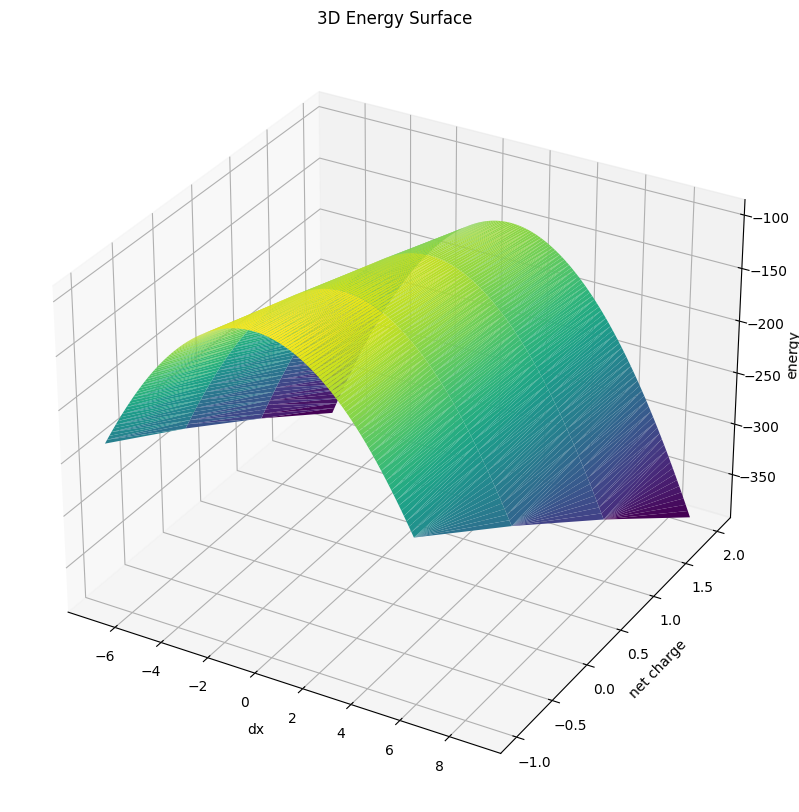

In [63]:
# Graph the data

x1 = pd.to_numeric(diatomic_data['dx'].apply(lambda x: x[0]))
x2 = pd.to_numeric(diatomic_data['net charge'])
# x1_mesh, x2_mesh = np.meshgrid(x1, x2)
y = pd.to_numeric(diatomic_data['energy'])

# integer_x1 = x1[x1.astype(int) == x1]
# integer_x2 = x2[x1.astype(int) == x1]
# integer_y = y[x1.astype(int) == x1]

fig = plt.figure()
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

ax.plot_trisurf(x1, x2, y, cmap='viridis')

ax.set_xlabel('dx')
ax.set_ylabel('net charge')
ax.set_zlabel('energy')
ax.set_title('3D Energy Surface')

plt.show()

In [ ]:
def get_diatomic_data(ap_mol):
    """ 
    Get the diatomic molecule data and store them in pandas dataframe
    If there exist a file with pre-calculated diatomic energy, directly open it.
    If not, calculate the energy for each molecule and store the data as a separate file

    Args:
        ap_mol (APDFT_perturbator): the reference molecule (used for APDFT calculations)
    
    Returns:
        diatomic_data (pandas dataframe): dataframe containing the perturbation vector and the energy of each molecule
    """
    
    if os.path.isfile('../Data/extended_diatomic_data_w_energy.csv'):
        diatomic_data = pd.read_csv('../Data/extended_diatomic_data_w_energy.csv', header = 0)
        diatomic_data['dx'] = diatomic_data['dx'].apply(lambda x: ast.literal_eval(x))
    
    elif os.path.isfile('../Data/diatomic_data.csv'):
        diatomic_data = pd.read_csv('diatomic_data.csv', header = 0)
        
        # creating the dx column and calculate the total energy of each molecule
        diatomic_data['dx'] = None
        diatomic_data['energy'] = None

        for index, row in diatomic_data.iterrows():
            dx = [row['charge_1'] - 7, row['charge_2'] - 7] # calculates the dx vector from the charge of each atom
            
            # target_mol = FcM_like(mol, fcs=dx) # build target molecule from specified perturbation
            target_energy = ap_mol.target_energy(dx)

            diatomic_data.at[index, 'dx'] = dx
            diatomic_data.at[index, 'energy'] = target_energy
            diatomic_data.to_csv('../Data/diatomic_data_w_energy.csv')
    
    return diatomic_data

In [ ]:
diatomic_data = get_diatomic_data(ap_nn)
display(diatomic_data)
# print(diatomic_data['dx'].dtype)

In [ ]:
# creating the dx column and calculate the total energy of each molecule

# diatomic_data['dx'] = None
# diatomic_data['energy'] = None

# for index, row in diatomic_data.iterrows():
#     dx = [row['charge_1'] - 7, row['charge_2'] - 7] # calculates the dx vector from the charge of each atom
#     energy = ap_nn.target_energy(dx) # calculates the energy of the molecule
#     diatomic_data.at[index, 'dx'] = dx
#     diatomic_data.at[index, 'energy'] = energy
# print(diatomic_data)

In [ ]:
# diatomic_data.to_csv('diatomic_data_w_energy.csv', index=False)

In [ ]:
# express each molecule using the ANM basis
# i.e. c = Q_inv @ dx

dx_array = np.array(diatomic_data['dx'].tolist())
# print(dx_array)

c_array = (Q_inv @ dx_array.T).T
# print(c_array)

# print(c_array.tolist())

diatomic_data['c'] = c_array.tolist()
diatomic_data['coord_0'] = diatomic_data['c'].apply(lambda x: x[0])
diatomic_data['coord_1'] = diatomic_data['c'].apply(lambda x: x[1])

display(diatomic_data)

## Regression ##

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
import warnings

In [ ]:
X = diatomic_data[['coord_0', 'coord_1']]
y = diatomic_data['energy']

### Gaussian Kernel ###

In [ ]:
# Gaussian kernel

gaussian_KRR = KernelRidge(kernel='rbf', gamma=0.05, alpha = 0.05)

k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores = cross_val_score(gaussian_KRR, X, y, scoring='neg_mean_squared_error', cv=k_fold)
mse_scores = -mse_scores  # Convert negative MSE scores to positive

# Calculate the average error across all folds
avg_mse = mse_scores.mean()

# Print the mean squared error for each fold
for fold, mse in enumerate(mse_scores):
    print(f"Fold {fold+1}: MSE = {mse}")

# Print the average mean squared error
print(f"Average MSE across all folds: {avg_mse}")

### Polynomial Kernel ###

In [ ]:
# Polynomial Kernel

poly_KRR = KernelRidge(kernel='polynomial', degree=3, alpha = 0.01)

k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores = cross_val_score(poly_KRR, X, y, scoring='neg_mean_squared_error', cv=k_fold)
mse_scores = -mse_scores  # Convert negative MSE scores to positive

# Calculate the average error across all folds
avg_mse = mse_scores.mean()

# Print the mean squared error for each fold
for fold, mse in enumerate(mse_scores):
    print(f"Fold {fold+1}: MSE = {mse}")

# Print the average mean squared error
print(f"Average MSE across all folds: {avg_mse}")

### Ridge Regression ###

In [ ]:
ridge_regression = Ridge(alpha=0.01)

k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores = cross_val_score(ridge_regression, X, y, scoring='neg_mean_squared_error', cv=k_fold)
mse_scores = -mse_scores  # Convert negative MSE scores to positive

# Calculate the average error across all folds
avg_mse = mse_scores.mean()

# Print the mean squared error for each fold
for fold, mse in enumerate(mse_scores):
    print(f"Fold {fold+1}: MSE = {mse}")

# Print the average mean squared error
print(f"Average MSE across all folds: {avg_mse}")

## Hyperparameter Tuning ##

### Gaussian Kernel ###

In [ ]:
# # Grid Search Round 1

# param_grid = {
#     'alpha': np.logspace(np.log10(1e-5), np.log10(100), num=20),  # Regularization parameter controlling the L2 regularization term
#     'gamma': np.logspace(np.log10(1e-5), np.log10(100), num=20),  # Parameter for the Gaussian kernel, controlling the width of the kernel
#     'kernel': ['rbf'],  # Specifies the kernel function to be used, in this case, the Gaussian (RBF) kernel
# }


# gaussian_KRR = KernelRidge()

# k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
# grid_search = GridSearchCV(gaussian_KRR, param_grid, scoring='neg_mean_squared_error', cv=k_fold)
# grid_search.fit(X, y)

# best_params = grid_search.best_params_
# best_score = -grid_search.best_score_

# # Print the best hyperparameters and score
# print("Best Hyperparameters:", best_params)
# print("Best Mean Squared Error:", best_score)

In [ ]:
# # Grid Search Round 2

# param_grid = {
#     'alpha': np.logspace(np.log10(1e-7), np.log10(1e-5), num=20),  # Regularization parameter controlling the L2 regularization term
#     'gamma': np.logspace(np.log10(0.001), np.log10(0.1), num=20),  # Parameter for the Gaussian kernel, controlling the width of the kernel
#     'kernel': ['rbf'],  # Specifies the kernel function to be used, in this case, the Gaussian (RBF) kernel
# }


# gaussian_KRR = KernelRidge()

# k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
# grid_search = GridSearchCV(gaussian_KRR, param_grid, scoring='neg_mean_squared_error', cv=k_fold)
# grid_search.fit(X, y)

# best_params = grid_search.best_params_
# best_score = -grid_search.best_score_

# # Print the best hyperparameters and score
# print("Best Hyperparameters:", best_params)
# print("Best Mean Squared Error:", best_score)

In [ ]:
# # Grid Search Round 3

# param_grid = {
#     'alpha': np.logspace(np.log10(1e-9), np.log10(1e-7), num=20),  # Regularization parameter controlling the L2 regularization term
#     'gamma': np.linspace(0.003, 0.005, num=20),  # Parameter for the Gaussian kernel, controlling the width of the kernel
#     'kernel': ['rbf'],  # Specifies the kernel function to be used, in this case, the Gaussian (RBF) kernel
# }


# gaussian_KRR = KernelRidge()

# k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
# grid_search = GridSearchCV(gaussian_KRR, param_grid, scoring='neg_mean_squared_error', cv=k_fold)
# grid_search.fit(X, y)

# best_params = grid_search.best_params_
# best_score = -grid_search.best_score_

# # Print the best hyperparameters and score
# print("Best Hyperparameters:", best_params)
# print("Best Mean Squared Error:", best_score)

In [ ]:
# # Grid Search Round 4

# param_grid = {
#     'alpha': np.logspace(np.log10(1e-11), np.log10(1e-9), num=20),  # Regularization parameter controlling the L2 regularization term
#     'gamma': np.linspace(0.003, 0.005, num=20),  # Parameter for the Gaussian kernel, controlling the width of the kernel
#     'kernel': ['rbf'],  # Specifies the kernel function to be used, in this case, the Gaussian (RBF) kernel
# }


# gaussian_KRR = KernelRidge()

# k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
# grid_search = GridSearchCV(gaussian_KRR, param_grid, scoring='neg_mean_squared_error', cv=k_fold)
# grid_search.fit(X, y)

# best_params = grid_search.best_params_
# best_score = -grid_search.best_score_

# # Print the best hyperparameters and score
# print("Best Hyperparameters:", best_params)
# print("Best Mean Squared Error:", best_score)

In [ ]:
# # Grid Search Round 5

# param_grid = {
#     'alpha': np.linspace(2e-11, 3e-11, num=21),  # Regularization parameter controlling the L2 regularization term
#     'gamma': np.linspace(0.003, 0.005, num=20),  # Parameter for the Gaussian kernel, controlling the width of the kernel
#     'kernel': ['rbf'],  # Specifies the kernel function to be used, in this case, the Gaussian (RBF) kernel
# }


# gaussian_KRR = KernelRidge()

# k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
# grid_search = GridSearchCV(gaussian_KRR, param_grid, scoring='neg_mean_squared_error', cv=k_fold)
# grid_search.fit(X, y)

# best_params = grid_search.best_params_
# best_score = -grid_search.best_score_

# # Print the best hyperparameters and score
# print("Best Hyperparameters:", best_params)
# print("Best Mean Squared Error:", best_score)

### Polynomial Kernel ###

In [ ]:
# # Hyperparam tuning
# # Grid search round 1

# param_grid = {
#     'alpha': np.logspace(np.log10(1e-5), np.log10(100), num=50),
#     'kernel': ['poly'],  
#     'degree': [1, 2, 3, 4], 
#     'coef0': np.logspace(np.log10(1e-5), np.log10(100), num=50), 
# }

# poly_KRR = KernelRidge()

# k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
# grid_search = GridSearchCV(poly_KRR, param_grid, scoring='neg_mean_squared_error', cv=k_fold)
# grid_search.fit(X, y)

# best_params = grid_search.best_params_
# best_score = -grid_search.best_score_

# # Print the best hyperparameters and score
# print("Best Hyperparameters:", best_params)
# print("Best Mean Squared Error:", best_score)

In [ ]:
# # Hyperparam tuning
# # Grid search round 2

# param_grid = {
#     'alpha': np.logspace(np.log10(1e-6), np.log10(1e-4), num=30),
#     'kernel': ['poly'],  
#     'degree': [2, 3, 4], 
#     'coef0': np.linspace(50, 100, num=51), 
# }

# poly_KRR = KernelRidge()

# k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
# grid_search = GridSearchCV(poly_KRR, param_grid, scoring='neg_mean_squared_error', cv=k_fold)
# grid_search.fit(X, y)

# best_params = grid_search.best_params_
# best_score = -grid_search.best_score_

# # Print the best hyperparameters and score
# print("Best Hyperparameters:", best_params)
# print("Best Mean Squared Error:", best_score)

In [ ]:
# # Hyperparam tuning
# # Grid search round 3

# param_grid = {
#     'alpha': np.logspace(np.log10(1e-8), np.log10(1e-6), num=20),
#     'kernel': ['poly'],  
#     'degree': [4], 
#     'coef0': np.linspace(100, 200, num=51), 
# }

# poly_KRR = KernelRidge()

# k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore")
#     grid_search = GridSearchCV(poly_KRR, param_grid, scoring='neg_mean_squared_error', cv=k_fold)
#     grid_search.fit(X, y)

# best_params = grid_search.best_params_
# best_score = -grid_search.best_score_

# # Print the best hyperparameters and score
# print("Best Hyperparameters:", best_params)
# print("Best Mean Squared Error:", best_score)

In [ ]:
# # Hyperparam tuning
# # Grid search round 4

# param_grid = {
#     'alpha': np.logspace(np.log10(1e-7), np.log10(1e-6), num=20),
#     'kernel': ['poly'],  
#     'degree': [4], 
#     'coef0': np.linspace(170, 200, num=31), 
# }

# poly_KRR = KernelRidge()

# k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore")
#     grid_search = GridSearchCV(poly_KRR, param_grid, scoring='neg_mean_squared_error', cv=k_fold)
#     grid_search.fit(X, y)

# best_params = grid_search.best_params_
# best_score = -grid_search.best_score_

# # Print the best hyperparameters and score
# print("Best Hyperparameters:", best_params)
# print("Best Mean Squared Error:", best_score)

### Ridge Regression ###

In [ ]:
# # Grid Search
# # Round 1

# ridge_model = Ridge()

# # Define the hyperparameters to tune and their respective values
# param_grid = {
#     'alpha': np.logspace(np.log10(0.0001), np.log10(1000), num=80),  # Regularization strength
#     'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg'],  # Solver algorithm
# }

# # Perform grid search using cross-validation
# grid_search = GridSearchCV(ridge_model, param_grid, cv=5, scoring='neg_mean_squared_error')
# grid_search.fit(X, y)

# # Retrieve the best hyperparameters and the corresponding mean squared error
# best_params = grid_search.best_params_
# best_mse = -grid_search.best_score_

# # Print the best hyperparameters and the corresponding mean squared error
# print("Best Hyperparameters:")
# print(best_params)
# print("Best Mean Squared Error:", best_mse)

## Learning Curve ##

In [ ]:
def evaluate_performance(model, X, y, num_training_sample, num_trials):

    """ 
    Given the number of training samples used, 
    calculate the average and standard deviation of MSE across a certain number of trials.
    For each trial, a specified number of training examples is used to train the model, 
    which is then evaluated on the rest of the data set.

    Args:
        X (ndarray): training data; size (N, m) where N is the number of training examples and m is the number of features
        y (ndarray): target data; size (N, 1)
        num_training_sample (int): the number of samples used for training
        num_trials: the number of trials 
    
    Returns:
        average_error: the average MSE across all trials
        std_dev_error: standard deviation of the error across all trials
    """

    errors = []
    test_size = 1.0 - num_training_sample/X.shape[0]

    for i in range(num_trials):
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, shuffle=True, random_state=i)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        error = np.sqrt(mean_squared_error(y_val, y_pred)) # Root mean squared error
        errors.append(error)
    
    average_error = np.mean(errors)
    std_dev_error = np.std(errors)
    return average_error, std_dev_error

### Gaussian Kernel ###

In [ ]:
# Gaussian Kernel

best_params_gaussian_KRR = {'alpha': 2.45e-11, 'gamma': 0.005, 'kernel': 'rbf'}
gaussian_KRR_model = KernelRidge(**best_params_gaussian_KRR)

columns = ['training size', 'average RMSE', 'standard deviation']
model_performance_gaussian_KRR = pd.DataFrame(columns=columns)

training_size = [i for i in range(1, 21)]
num_trials = 20

for num_training_sample in training_size:
    index = num_training_sample - 1
    average_error, std_dev_error = evaluate_performance(gaussian_KRR_model, X, y, num_training_sample, num_trials)
    model_performance_gaussian_KRR.at[index, 'training size'] = num_training_sample
    model_performance_gaussian_KRR.at[index, 'average RMSE'] = average_error
    model_performance_gaussian_KRR.at[index, 'standard deviation'] = std_dev_error/np.sqrt(num_trials)

display(model_performance_gaussian_KRR)

### Polynomial Kernel ###

In [ ]:
best_params_poly_KRR = {'alpha': 1.2742749857031348e-07, 'coef0': 188.0, 'degree': 4, 'kernel': 'poly'}
poly_KRR_model = KernelRidge(**best_params_poly_KRR)

columns = ['training size', 'average RMSE', 'standard deviation']
model_performance_poly_KRR = pd.DataFrame(columns=columns)

training_size = [i for i in range(1, 21)]
num_trials = 20

with warnings.catch_warnings():
    for num_training_sample in training_size:
        warnings.filterwarnings("ignore")
        index = num_training_sample - 1
        average_error, std_dev_error = evaluate_performance(poly_KRR_model, X, y, num_training_sample, num_trials)
        model_performance_poly_KRR.at[index, 'training size'] = num_training_sample
        model_performance_poly_KRR.at[index, 'average RMSE'] = average_error
        model_performance_poly_KRR.at[index, 'standard deviation'] = std_dev_error/np.sqrt(num_trials)

display(model_performance_poly_KRR)

In [ ]:
# # graphing

# graph_x = model_performance['training size']
# graph_y = model_performance['average RMSE']
# graph_error = model_performance['standard deviation']

# # Set figure size
# plt.figure(figsize=(10, 6))

# # Create line plot with error bars
# plt.errorbar(graph_x, graph_y, yerr=graph_error, marker='o', linestyle='-', capsize=4)

# # Set axis labels and title
# plt.xlabel('Training Size')
# plt.ylabel('Average RMSE')
# plt.title('Learning curve for diatomic molecule energy prediction using polynomial KNN')

# plt.xscale('log')
# plt.yscale('log')


# # Save the figure as a PNG image
# plt.savefig('learning_curve_20_points.png', dpi=300)
# plt.show()

In [ ]:
# No error bar
# Set figure size
plt.figure(figsize=(10, 6))

# Load the data
x = model_performance_poly_KRR['training size']
y1 = model_performance_poly_KRR['average RMSE']
y2 = model_performance_gaussian_KRR['average RMSE']

# Plotting
plt.plot(x, y1, label='Polynomial KRR', marker='o', linestyle='-', linewidth=2.5)
plt.plot(x, y2, label='Gaussian KRR', marker='o', linestyle='-', linewidth=2.5)

# Customize the x label
plt.xticks(range(1, 21), rotation=45, ha='center') 
plt.gca().xaxis.set_tick_params(which='both', labelbottom=True)

# Customize the plot
plt.title('Learning curve for diatomic molecule energy prediction')
plt.xlabel('Training Size')
plt.ylabel('Average RMSE [Ha] (log)')
plt.legend()

# Create log scale
plt.xscale('log', base=2)
plt.yscale('log')

# Display the plot
plt.savefig('../Graph/[Diatomic] learning_curve_no_error_bar.png', dpi=300)
plt.show()

In [ ]:
# With error bar
# Set figure size
plt.figure(figsize=(10, 6))

# Load the data
x = model_performance_poly_KRR['training size']
y1 = model_performance_poly_KRR['average RMSE']
y2 = model_performance_gaussian_KRR['average RMSE']
y1_error = model_performance_poly_KRR['standard deviation']
y2_error = model_performance_gaussian_KRR['standard deviation']

# Plotting
plt.errorbar(x, y1, label='Polynomial KRR', yerr=y1_error, marker='o', linestyle='-', capsize=3)
plt.errorbar(x, y2, label='Gaussian KRR', yerr=y2_error, marker='o', linestyle='-', capsize=3)
# plt.plot(x, y1, label='Polynomial KRR', marker='o', linestyle='-', linewidth=2.5)
# plt.plot(x, y2, label='Gaussian KRR', marker='o', linestyle='-', linewidth=2.5)

# Customize the x label
plt.xticks(range(1, 21), rotation=45, ha='center') 
plt.gca().xaxis.set_tick_params(which='both', labelbottom=True)

# Customize the plot
plt.title('Learning curve for diatomic molecule energy prediction')
plt.xlabel('Training Size')
plt.ylabel('Average RMSE [Ha] (log)')
plt.legend()

# Create log scale
plt.xscale('log', base=2)
plt.yscale('log')

# Display the plot
plt.savefig('../Graph/[Diatomic] learning_curve_with_error_bar.png', dpi=300)
plt.show()